# Clifford Notebok

- Some of the tests for Clifford composition aren't testing what I think they are.
- What about high/low...

In [2]:
import tqdm
import os
import pickle
from collections import Counter
import itertools
import random
import numpy as np
from scipy.sparse import csr_array
import networkx as nx
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import qiskit
from qiskit.quantum_info import random_clifford, Clifford
from qiskit.synthesis import synth_clifford_full
from qiskit import Aer, execute, QuantumCircuit

#sys.path.append("..")
#import qcircuitnlp.utils as utils
import clifford as cl

In [3]:
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from cycler import cycler

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rc('font', family='serif',size=14)
#matplotlib.rc('text', usetex=True)
matplotlib.rc('legend', fontsize=14)
plt.rcParams['ytick.minor.size'] = 3.0
matplotlib.rcParams.update({"axes.grid" : True, 
                            "grid.alpha": 0.75,
                            "grid.linewidth": 0.5})
matplotlib.rcParams['axes.prop_cycle'] = cycler(color=['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8'])
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
colors = colors + colors

In [5]:
## if there is a GPU, use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
print(device)

cpu


In [6]:
## Set RNG
rng = np.random.default_rng(1337)

## Preliminaries

How does the size of the Clifford group scale with circuit width $n$ (qubits)?

In [ ]:
for n in range(2, 7):
    print(f'n = {n}')
    print(f'  Move set size = {int(cl.size_movet_set(n))}')
    print(f'  Clifford group size = {np.exp(cl.clifford_log_dim(n)):.2e}')

Inspect a random sequence

In [ ]:
cl.random_sequence(rng, 10, 3)

In [ ]:
problem = cl.Problem(5, drop_phase_bits=True)
def build_candidates():
    return np.einsum('ij, mjk -> mik', 1*problem.state.tableau[:,:-1], problem.move_set_array) % 2

%timeit build_candidates()

In [ ]:
problem = cl.Problem(5, drop_phase_bits=False)
candidates = [problem.state & tableau for tableau in problem.move_set_tableau.values()]
def build_candidates(candidates=None):
    if candidates is None:
        candidates = [problem.state & tableau for tableau in problem.move_set_tableau.values()]
    return np.asarray([candidate.tableau for candidate in candidates])

In [ ]:
%timeit build_candidates(candidates)

In [ ]:
%timeit build_candidates()

## Data Analysis

Analyze the data generated by running `clifford.py` for various circuit widths.

In [35]:
## make a figure directory
if not os.path.exists('figures'):
    os.makedirs('figures')

In [127]:
## print out list of circuit widths for which there is data
drop_phase_bits = True

if drop_phase_bits:
    data_dirs = [dir for dir in os.listdir('data') if 'data_n' in dir and 'phase' in dir]
else:
    data_dirs = [dir for dir in os.listdir('data') if 'data_n' in dir and 'phase' not in dir]

num_qubit_list = np.sort([int(x.split('_')[2]) for x in data_dirs])[:-1]
#num_qubit_list = [3,4,5,6]

if drop_phase_bits:
    data_dirs = {n : f'data_n_{n}_drop_phase_bits' for n in num_qubit_list}
else:
    data_dirs = {n : f'data_n_{n}' for n in num_qubit_list}

data_dirs

{3: 'data_n_3_drop_phase_bits',
 4: 'data_n_4_drop_phase_bits',
 5: 'data_n_5_drop_phase_bits',
 6: 'data_n_6_drop_phase_bits',
 7: 'data_n_7_drop_phase_bits',
 8: 'data_n_8_drop_phase_bits',
 10: 'data_n_10_drop_phase_bits',
 12: 'data_n_12_drop_phase_bits'}

Examine the loss, both throughout training and the final value.

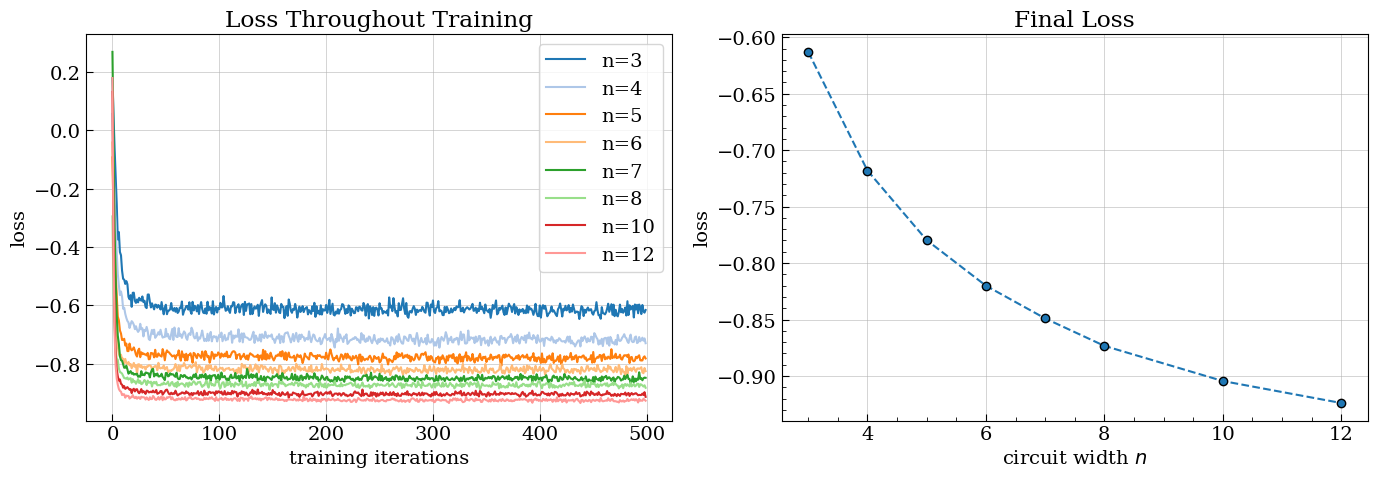

In [134]:
## use a different color scheme to plot a large number of curves
name = "tab20"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors_tab = cmap.colors  # type: list

fig, ax = plt.subplots(1, 2, figsize=(2*7,5))
[ax[i].set_prop_cycle(color=colors_tab) for i in range(len(ax))]

final_loss_list = []
for num_qubits in num_qubit_list:
    
    loss_history = np.load('data/' + data_dirs[num_qubits] + '/loss_history.npy')        
    ax[0].plot(np.asarray(loss_history), label=f'n={num_qubits}')
    final_loss_list.append(np.mean(loss_history[-10:]))
    
ax[0].set_xlabel('training iterations')
ax[0].set_ylabel('loss')
ax[0].set_title('Loss Throughout Training')
ax[0].legend()#bbox_to_anchor=(-0.2, 1))

ax[1].plot(num_qubit_list, final_loss_list, '--o', markeredgecolor='k')
ax[1].set_xlabel(r'circuit width $n$')
ax[1].set_ylabel('loss')
ax[1].set_title('Final Loss')

plt.minorticks_on()
plt.tight_layout()
plt.savefig('figures/training_history.png')

plt.show()

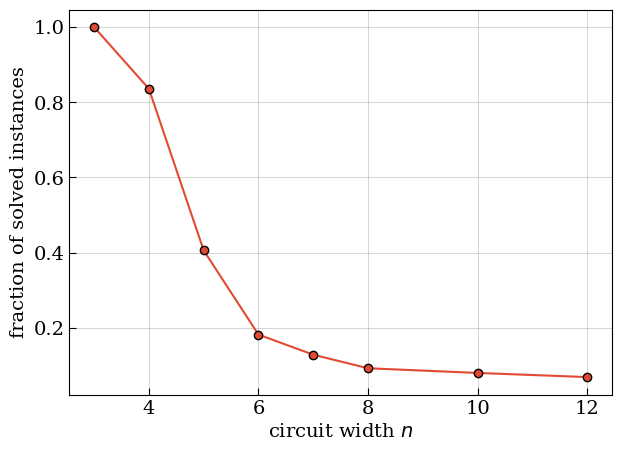

In [136]:
fraction_of_solved_instances = []
for i, num_qubits in enumerate(num_qubit_list):
    
    with open(f'data/' + data_dirs[num_qubits] + '/steps_until_success.pkl', 'rb') as f:
        steps_until_success = pickle.load(f)
    
    fraction_of_solved_instances.append(
        len([x for x in steps_until_success['lgf']['weighted_steps'] if x is not None]) 
            / len(steps_until_success['lgf']['weighted_steps'])
    )

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(num_qubit_list, fraction_of_solved_instances, '-o', markeredgecolor='k')
ax.set_xlabel(r'circuit width $n$')
ax.set_ylabel(r'fraction of solved instances')
plt.show()

Show the results for the LGF greedy algorithm.

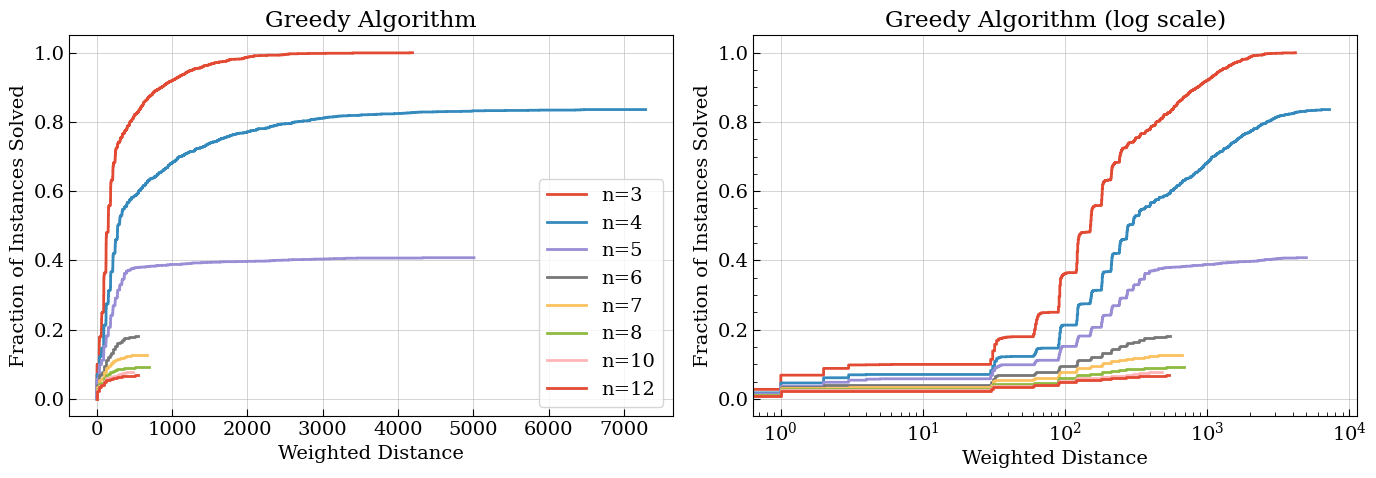

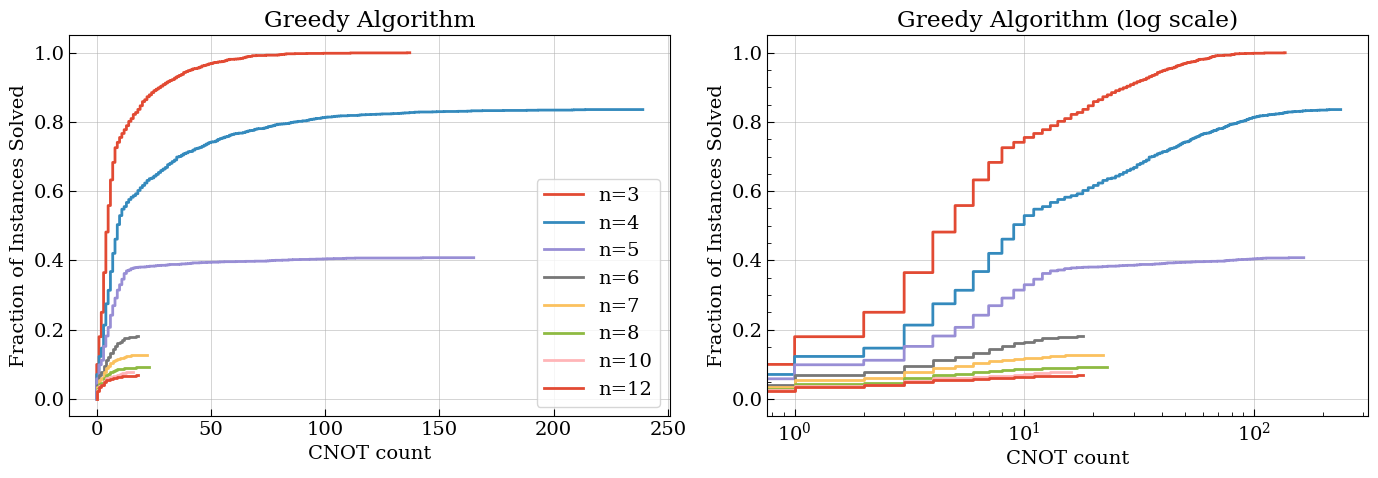

In [140]:
xlabel_dict = {
    'weighted_steps' : 'Weighted Distance',
    'CNOTs' : 'CNOT count'
    }
for metric, xlabel in xlabel_dict.items():

    fig, ax = plt.subplots(1, 2, figsize=(2*7,5))
    #ax[0].set_prop_cycle(color=colors)
    #ax[1].set_prop_cycle(color=colors)

    for i, num_qubits in enumerate(num_qubit_list):
        
        with open(f'data/' + data_dirs[num_qubits] + '/steps_until_success.pkl', 'rb') as f:
            steps_until_success = pickle.load(f)

        cum_steps_utils_success_lgf = np.sort([n for n in steps_until_success['lgf'][metric] if n is not None])

        ax[0].step(
            cum_steps_utils_success_lgf, 
            np.arange(len(cum_steps_utils_success_lgf))/len(steps_until_success['lgf'][metric]), 
            label=f'n={num_qubits}',
            linewidth=2, alpha=1.0, linestyle='-', color=colors[i]
            )
        ax[1].step(
            cum_steps_utils_success_lgf, 
            np.arange(len(cum_steps_utils_success_lgf))/len(steps_until_success['lgf'][metric]), 
            label=f'n={num_qubits}',
            linewidth=2, alpha=1.0, linestyle='-', color=colors[i]
            )

    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('Fraction of Instances Solved')
    ax[0].legend()
    ax[0].set_title('Greedy Algorithm')

    ax[1].set_xscale('log')
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('Fraction of Instances Solved')
    ax[1].set_title('Greedy Algorithm (log scale)')

    plt.minorticks_on()
    plt.tight_layout()

    plt.show()

Now add in the comparison with the built-in Qiskit method.

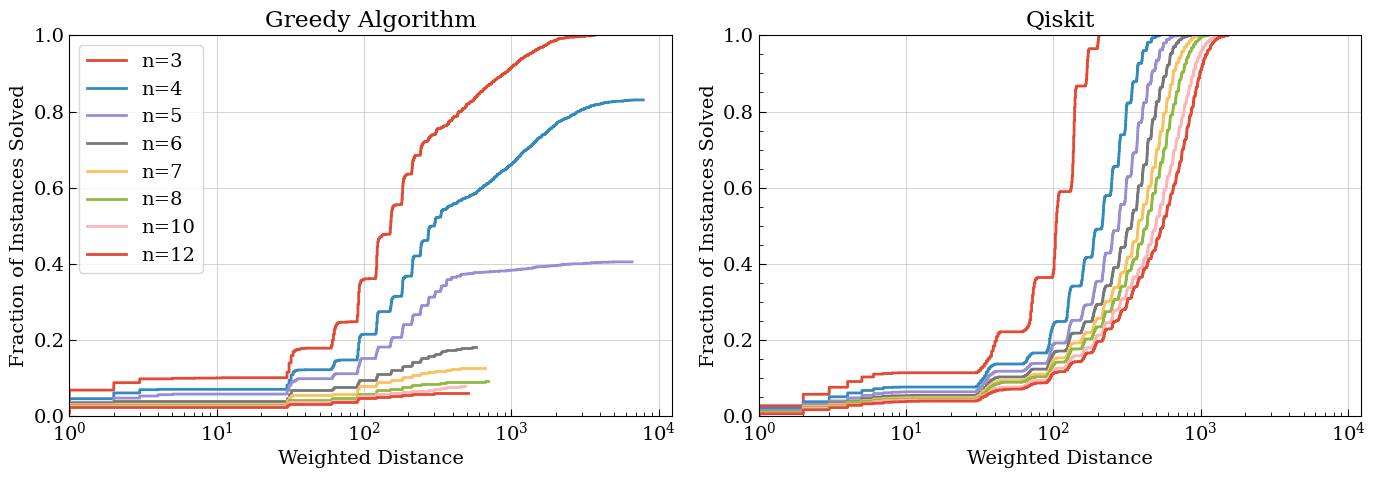

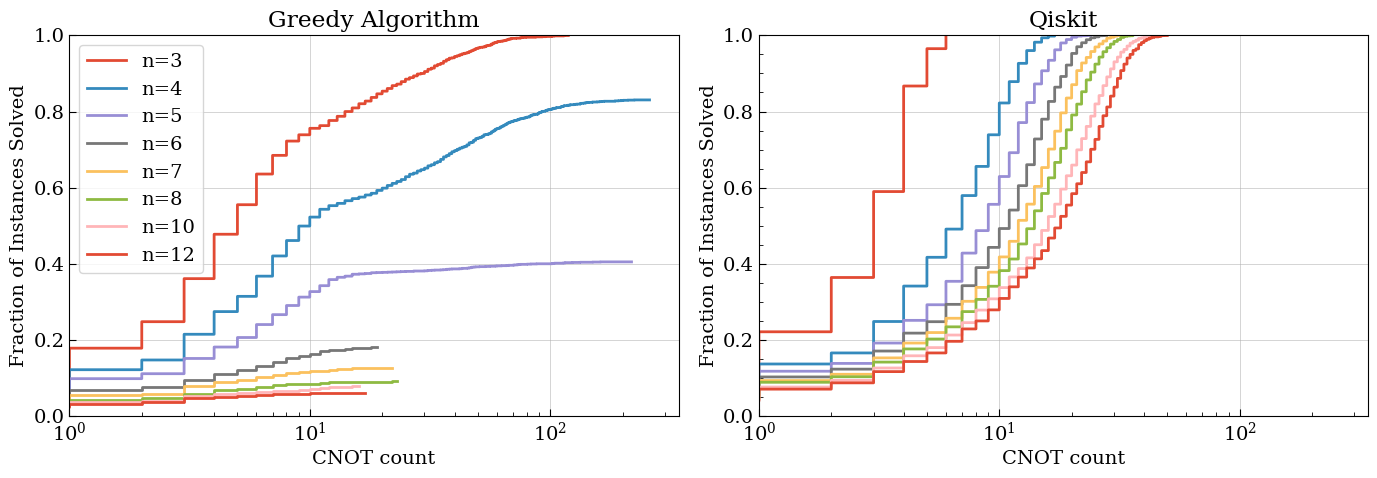

In [131]:
for metric, xlabel in xlabel_dict.items():

    fig, ax = plt.subplots(1, 2, figsize=(2*7,5))

    for i, num_qubits in enumerate(num_qubit_list):
        
        with open(f'data/' + data_dirs[num_qubits] + '/steps_until_success.pkl', 'rb') as f:
            steps_until_success = pickle.load(f)
        
        cum_steps_utils_success_lgf = np.sort([n for n in steps_until_success['lgf'][metric] if n is not None])
        #cum_steps_utils_success_random = np.sort([n for n in steps_until_success['random'] if n is not None])
        cum_steps_utils_success_qiskit = np.sort([n for n in steps_until_success['qiskit'][metric] if n is not None])

        ax[0].step(
            cum_steps_utils_success_lgf, 
            np.arange(len(cum_steps_utils_success_lgf))/len(steps_until_success['lgf'][metric]), 
            label=f'n={num_qubits}',
            linewidth=2, alpha=1.0, linestyle='-', color=colors[i]
            )
        ax[1].step(
            cum_steps_utils_success_qiskit, 
            np.arange(len(cum_steps_utils_success_qiskit))/len(steps_until_success['qiskit'][metric]), 
            label=f'qiskit n={num_qubits}',
            linewidth=2, alpha=1.0, linestyle='-', color=colors[i]
            )

    ax[0].set_xscale('log')
    ax[1].set_xscale('log')

    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('Fraction of Instances Solved')
    ax[0].set_title('Greedy Algorithm')
    ax[0].legend()
    ax[0].set_xlim([1, max(ax[0].get_xlim()[1], ax[1].get_xlim()[1])])
    ax[0].set_ylim([0,1])

    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('Fraction of Instances Solved')
    ax[1].set_title('Qiskit')
    ax[1].set_xlim([1, max(ax[0].get_xlim()[1], ax[1].get_xlim()[1])])
    ax[1].set_ylim([0,1])

    plt.minorticks_on()
    plt.tight_layout()
    plt.savefig(f'figures/cumulative_plot_{xlabel}.png')
    plt.show()

In [133]:
for metric, xlabel in xlabel_dict.items():

    fig, ax = plt.subplots(3, 4, figsize=(4*7,3*5), dpi=400)
    ax = ax.flatten()

    ## loop over all circuit widths
    for i, num_qubits in enumerate(num_qubit_list):
        
        with open(f'data/' + data_dirs[num_qubits] + '/steps_until_success.pkl', 'rb') as f:
            steps_until_success = pickle.load(f)

        cum_steps_utils_success_lgf = np.sort([n for n in steps_until_success['lgf'][metric] if n is not None])
        #cum_steps_utils_success_random = np.sort([n for n in steps_until_success['random'] if n is not None])
        cum_steps_utils_success_qiskit = np.sort([n for n in steps_until_success['qiskit'][metric] if n is not None])

        ax[i].step(
            cum_steps_utils_success_qiskit, 
            np.arange(len(cum_steps_utils_success_qiskit))/len(steps_until_success['qiskit'][metric]), 
            label=f'Qiskit',
            linewidth=3, alpha=1.0, linestyle='-', color='k'
            )    
        ax[i].step(
            cum_steps_utils_success_lgf, 
            np.arange(len(cum_steps_utils_success_lgf))/len(steps_until_success['lgf'][metric]), 
            label=f'Greedy',
            linewidth=3, alpha=1.0, linestyle='--', color='k'
            )

        ax[i].set_title(f'n = {num_qubits}', fontsize=18)

    ## add the labels and other plotting instructions
    for i in range(len(ax)):

        ax[i].set_xscale('log')
        #ax.legend()
        #ax.set_xlim([1, max(ax[0].get_xlim()[1], ax[1].get_xlim()[1])])
        ax[i].set_ylim([0,1])

        if i == 0:
            ax[i].legend()
        if i >= 8:
            ax[i].set_xlabel(xlabel, fontsize=18)
        if i in [0, 4, 8]:
            ax[i].set_ylabel('Fraction of Instances Solved')

    plt.minorticks_on()
    plt.tight_layout()
    plt.savefig(f'figures/cumulative_plot_comparison_{xlabel}.png')
    plt.show()

In [139]:
metric = 'CNOTs'
#metric = 'weighted_steps'

ratio_improvement = {num_qubits:[] for num_qubits in num_qubit_list}
ratio_worsen = {num_qubits:[] for num_qubits in num_qubit_list}

for num_qubits in num_qubit_list:
    
    with open(f'data/' + data_dirs[num_qubits] + '/steps_until_success.pkl', 'rb') as f:
        steps_until_success = pickle.load(f)

    steps_utils_success_lgf = np.asarray(
        [x for x in steps_until_success['lgf'][metric] if x is not None]
        )
    steps_utils_success_qiskit = np.asarray(
        [x for i, x in enumerate(steps_until_success['qiskit'][metric]) if steps_until_success['lgf'][metric][i] is not None]
        )

    x = np.mean(steps_utils_success_qiskit > steps_utils_success_lgf)
    print(f'(n={num_qubits}): fraction of instances where lgf method beats qiskit: %.4f' %x)

    x = np.mean(steps_utils_success_qiskit >= steps_utils_success_lgf)
    print(f'(n={num_qubits}): fraction of instances where lgf method beats or matches qiskit: %.4f\n' %x)
    
    for i in range(len(steps_until_success['lgf'][metric])):

        if steps_until_success['lgf'][metric][i] is not None:
            if steps_until_success['lgf'][metric][i] < steps_until_success['qiskit'][metric][i]:
                ratio = - (steps_until_success['lgf'][metric][i] - steps_until_success['qiskit'][metric][i]) #/ steps_until_success['qiskit'][i]
                ratio_improvement[num_qubits].append(ratio)
            elif steps_until_success['lgf'][metric][i] > steps_until_success['qiskit'][metric][i]:
                ratio = (steps_until_success['lgf'][metric][i] - steps_until_success['qiskit'][metric][i]) #/ steps_until_success['qiskit'][i]
                ratio_worsen[num_qubits].append(ratio)

(n=3): fraction of instances where lgf method beats qiskit: 0.0000
(n=3): fraction of instances where lgf method beats or matches qiskit: 0.4690

(n=4): fraction of instances where lgf method beats qiskit: 0.1872
(n=4): fraction of instances where lgf method beats or matches qiskit: 0.6274

(n=5): fraction of instances where lgf method beats qiskit: 0.2166
(n=5): fraction of instances where lgf method beats or matches qiskit: 0.8960

(n=6): fraction of instances where lgf method beats qiskit: 0.1808
(n=6): fraction of instances where lgf method beats or matches qiskit: 0.9945

(n=7): fraction of instances where lgf method beats qiskit: 0.0973
(n=7): fraction of instances where lgf method beats or matches qiskit: 0.9961

(n=8): fraction of instances where lgf method beats qiskit: 0.0649
(n=8): fraction of instances where lgf method beats or matches qiskit: 1.0000

(n=10): fraction of instances where lgf method beats qiskit: 0.0813
(n=10): fraction of instances where lgf method beats or 

In [124]:
[np.median(ratio_improvement[n]) for n in num_qubit_list[1:]]

[2.0, 2.0, 2.0]

In [125]:
[np.mean(ratio_improvement[n]) for n in num_qubit_list[1:]]

[2.165016501650165, 2.4104046242774566, 2.109375]

(array([379.,  39.,   4.,  35.,   6.,   5.,  10.,   0.,   4.,   3.]),
 array([  1. ,  19.8,  38.6,  57.4,  76.2,  95. , 113.8, 132.6, 151.4,
        170.2, 189. ]),
 <BarContainer object of 10 artists>)

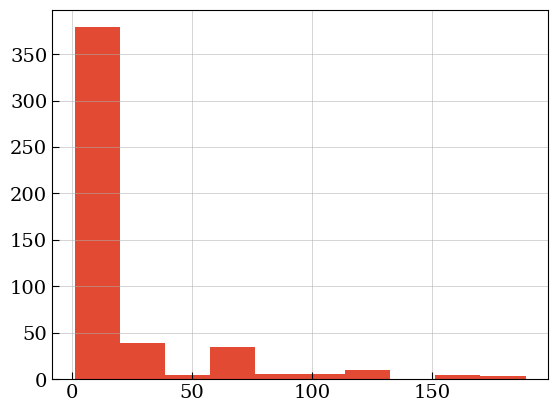

In [111]:
plt.hist(ratio_improvement[5])

Am I only beating Qiskit because I'm not worrying about the phase bits but they are? So their decomp requires more gates? See if I can do it with less cx and swap gates specifically.

/Users/gavinhartnett/miniforge3/envs/qlp/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


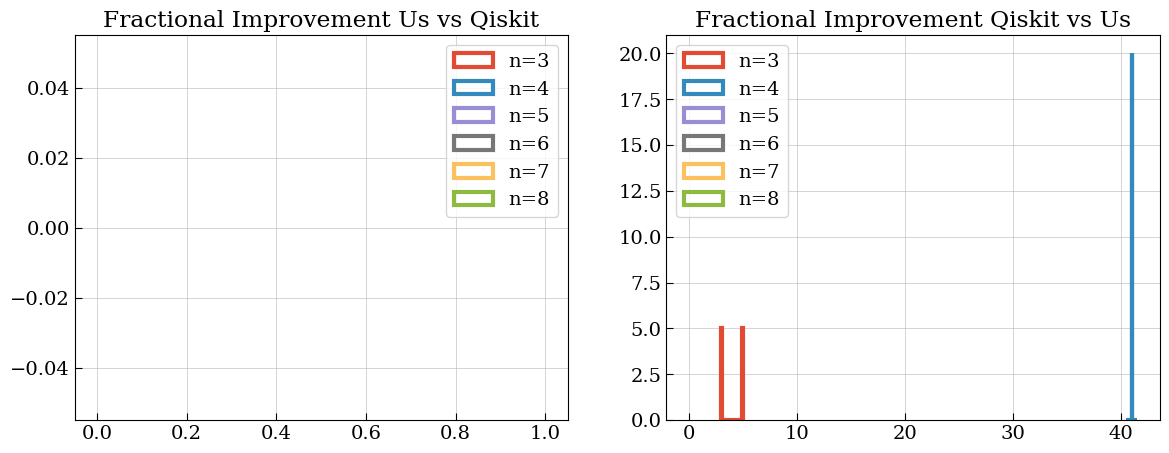

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(2*7,5))

for i, n in enumerate(num_qubit_list):
    ax[0].hist(
        ratio_improvement[n],
        50,
        label=f'n={n}', 
        density=True, 
        alpha=1, 
        histtype='step', 
        linewidth=3, color=colors[i]
        )
    ax[0].legend()
    ax[0].set_title('Fractional Improvement Us vs Qiskit')

    ax[1].hist(
        ratio_worsen[n], 
        20,
        label=f'n={n}', 
        density=True, 
        alpha=1, 
        histtype='step', 
        linewidth=3,
        color=colors[i]
        )
    ax[1].legend()
    ax[1].set_title('Fractional Improvement Qiskit vs Us')
    #ax[1].set_xlim([0,200])
    
plt.show()

In [ ]:
ratio_improvement

In [ ]:
ratio_worsen

Analyze the effect of the random seeds on the success/probability of the hillclimbing algorithm.

In [ ]:
num_qubits = 4
data_dir = f'data/data_n_{num_qubits}/'

lgf_model = cl.LGFModel(
    num_qubits = num_qubits,
    device = device,
    rng = rng,
    drop_phase_bit = True,
    hidden_layers = [32, 16, 4]
    )

checkpoint = torch.load(data_dir + 'checkpoint')
lgf_model.load_state_dict(checkpoint)

In [ ]:
with open(data_dir + 'args.pkl', 'rb') as f:
    x = pickle.load(f)
x

In [ ]:
max_iter = 1000
num_initial_state_trials = 100
num_hillclimb_trials = 100
success_matrix = np.zeros( (num_initial_state_trials, num_hillclimb_trials))

## loop over initial states
for initial_seed in range(num_initial_state_trials):

    problem = cl.Problem(lgf_model.num_qubits, seed=initial_seed)
    success_count = 0.0

    ## loop over hillclimbing seeds
    pbar = tqdm.trange(num_hillclimb_trials)
    for hillclimbing_seed in pbar:

        result = cl.hillclimbing(
            problem.state,
            lgf_model,
            max_iter=max_iter,
            seed=hillclimbing_seed,
            )

        success_matrix[initial_seed, hillclimbing_seed] = result['success'] * 1.0
        success_count += result['success'] * 1.0
        pbar.set_description("success rate=%.4f" % (success_count / (hillclimbing_seed + 1)))

In [ ]:
## average over initial state seeds
## each entry is a different hillclimbing seed
np.mean(success_matrix, axis=0)

In [ ]:
## average over hillclimbing seeds
## each entry is a different initial seed
np.mean(success_matrix, axis=1)

In [ ]:
def relative_weight_x_to_cx(fidelity_x, fidelity_cx):
    '''
    How many x gates are equivalent to a single cx gate, 
    in terms of fidelity reduction?
    '''
    return np.log(fidelity_cx) / np.log(fidelity_x)

relative_weight_x_to_cx(1 - 2.556e-4, 1 - 9.263e-3)

In [ ]:
weight_dict = {
    'x':1,
    'y':1,
    'z':1,
    'h':1,
    's':1,
    'sdg':1,
    'cx':30,
    'swap':90
    }
#cl.normalize_dict(weight_dict)
weight_dict